# **Тестовое задание OCR**

### Начинаем с pytesseract и API сайта https://ocr.space/OCRAPI

In [1]:
!pip install pytesseract

In [2]:
!sudo apt-get install tesseract-ocr-rus 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-rus
0 upgraded, 1 newly installed, 0 to remove and 74 not upgraded.
Need to get 1274 kB of archives.
After this operation, 3877 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-rus all 1:4.00~git30-7274cfa-1 [1274 kB]
Fetched 1274 kB in 1s (1483 kB/s)           
Selecting previously unselected package tesseract-ocr-rus.
(Reading database ... 106350 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-rus_1%3a4.00~git30-7274cfa-1_all.deb ...
Unpacking tesseract-ocr-rus (1:4.00~git30-7274cfa-1) ...
Setting up tesseract-ocr-rus (1:4.00~git30-7274cfa-1) ...


In [3]:
import os
import cv2
import base64
import string
import requests
import pytesseract
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
from typing import Set, Dict, Optional, Union, Callable, List, Tuple
from matplotlib import image as im
from urllib.parse import urlencode
from PIL import Image, ImageDraw, ImageFont
from random import randint, choice

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
%matplotlib inline

In [5]:
# чтобы моноканальные картинки не отображались зелёными
plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

In [6]:
# cкачиваем архив с фото
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/kVdTaY8TuGvBkw'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
with open('./downloaded_images.zip', 'wb') as f:
    f.write(download_response.content)

In [7]:
!unzip ./downloaded_images.zip
!rm ./downloaded_images.zip

Archive:  ./downloaded_images.zip
  inflating:  DataForOCR/0.jpeg      
  inflating:  DataForOCR/1.jpeg      
  inflating:  DataForOCR/2.jpeg      
  inflating:  DataForOCR/3.jpeg      
  inflating:  DataForOCR/4.png       
  inflating:  DataForOCR/5.jpeg      
  inflating:  DataForOCR/6.jpeg      
  inflating:  DataForOCR/7.jpeg      
  inflating:  DataForOCR/8.jpeg      
  inflating:  DataForOCR/9.jpeg      


In [8]:
# получаем шрифт courier new, такой используется в паспорте, он пригодится позже для генерации аналога MNIST
!wget https://fontsfree.net//wp-content/fonts/basic/serif/FontsFree-Net-cour.ttf -O courier.ttf

--2022-11-24 07:11:08--  https://fontsfree.net//wp-content/fonts/basic/serif/FontsFree-Net-cour.ttf
Resolving fontsfree.net (fontsfree.net)... 104.21.32.110, 172.67.151.18, 2606:4700:3033::6815:206e, ...
Connecting to fontsfree.net (fontsfree.net)|104.21.32.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 709600 (693K) [font/ttf]
Saving to: ‘courier.ttf’

courier.ttf         100%[===================>] 692.97K  --.-KB/s    in 0.02s   

2022-11-24 07:11:08 (27.2 MB/s) - ‘courier.ttf’ saved [709600/709600]



In [9]:
# находим все изображения в директории ноутбука, сюда был скачан архив и распакован
paths = set()

def walk(parent_path):
    childs = os.listdir(parent_path)
    for child in childs:
        child_path = os.path.join(parent_path, child)
        if os.path.isfile(child_path):
            if child_path.endswith(('.jpeg', '.png')):
                paths.add(child_path)
        elif os.path.isdir(child_path):
            walk(child_path)
            
walk('./')

In [90]:
# подготавливаем функции для обработки изображения, которые могут пригодиться

def simple_threshold(image: np.ndarray) -> np.ndarray:
    return cv2.threshold(image, 165, 255, cv2.THRESH_BINARY)[1]

def otsu_threshold(image: np.ndarray) -> np.ndarray:
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

def gaussian_threshold(image: np.ndarray) -> np.ndarray:
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

def resize(image: np.ndarray, size: Tuple[int, int] = (800, 800)) -> np.ndarray:
    return cv2.resize(image, size)
    
def crop(image: np.ndarray) -> np.ndarray:
    height, width = image.shape
    top = floor(height * 0.5)
    bottom = floor(height * 0.75)
    left = floor(width * 0.4)
    right = floor(width * 0.85)
    image = image[top: bottom]
    image = image.T[left: right].T
    return image

In [71]:
# один общий класс для обработки изображений 
class Pipeline:
    
    def __init__(self):
        self.image = None
        self.texts = []
        
    def load_image(self, path: str, gray: bool = True) -> None:
        if gray:
            self.image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        else:
            raise NotImplementedError
    
    def process_image(self,
                      resize_: Optional[Tuple] = None,
                      crop_: bool = False,
                      threshold_: Optional[str] = None) -> None:
        if resize_:
            self.image = resize(self.image, resize_)
        if crop_:
            self.image = crop(self.image)
        if threshold_:
            if threshold_ == 'otsu':
                self.image = otsu_threshold(self.image)
            if threshold_ == 'gaussian':
                self.image = gaussian_threshold(self.image)
            if threshold_ == 'simple':
                self.image = simple_threshold(self.image)
            else:
                raise NotImplementedError
        
    def get_text(self):
        raise NotImplementedError
    
    def show(self):
        plt.imshow(self.image)

In [72]:
# класс с использованием pytesseract
class TesseractPipeline(Pipeline):
    
    def get_text(self):
        lst = []
        data = pytesseract.image_to_data(image=self.image,
                                        lang='rus',
                                        output_type=pytesseract.Output.DICT)
        for word in data['text']:
            for letter in word:
                if letter.isalpha():
                    lst.append(word.strip().capitalize())
                    break
        return ' '.join(lst[:3])

In [73]:
tp = TesseractPipeline()
for path in paths:
    tp.load_image(path)
    tp.process_image(crop_=True)
    tp.texts.append(tp.get_text())

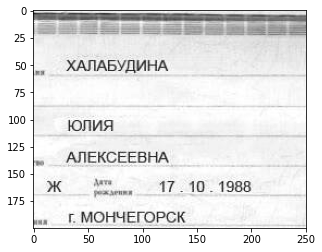

In [82]:
tp.show()

In [74]:
tp.texts

['',
 '',
 'Шапошникова Виктория Николаевна.',
 'Макаров Роман Юрьевич',
 'Васлевский Григорий. Петрович',
 'Имярек Евгений Александрович',
 'Дмитрий Ь Алексеевич',
 '',
 'Трамп Дональд Джон.',
 'Юлия Алексеевна. Г']

In [75]:
# с использованием API
class APIPipeline(Pipeline):
    
    payload = {
        'apikey': '52237ca65c88957',
        'language': 'rus',
        'OCREngine': 1
        }
    
    def get_text(self) -> str:
        
        text = ''
        im.imsave('temp.jpg', self.image)
        with open('temp.jpg', 'rb') as f:
            r = requests.post('https://api.ocr.space/parse/image',
                                  files={'filename': f},
                                  data=self.payload)
            raw_text = r.json()['ParsedResults'][0]['ParsedText']
            text_lst = raw_text.replace('\r', '').replace(' ', '').split('\n')
            for word in text_lst:
                if word.isalpha():
                    text += word.capitalize() + ' '
        return text[:-1] if len(text) else ''

In [80]:
ap = APIPipeline()
for path in paths:
    ap.load_image(path)
    ap.process_image(crop_=True)
    ap.texts.append(ap.get_text())

In [81]:
ap.texts

['',
 '',
 'Шапошникова Виктория Николаевна Краснознаменск',
 'Юрьевич',
 'Григорий Петрович',
 'Имярек Евгений Александрович Дата',
 'Даймонд Трий Дата Рождения',
 'Анатольевна Остно',
 'Трамп Дональд Джон',
 'Ж Халабудина Юлия Влексеевна']

#### Использования pytesseract и ocr-api показали себя не лучшим образом 
#### Тем не менее, pytesseract выделяет границы того текста, который не распознал. Отсюда возникла идея сегментировать изображение паспорта на более маленькие с текстом

# Концепция:
1) Сегментировать исходное изображение сперва на текстовые, затем на буквенные (при этом порядок текста будет очевиден по координатам верхних левых краёв каждого изображения внутри исходного)

2) Собрать/cгенерировать буквенный датасет, с шрифтом как в паспорте

3) Обучить модель подобную MNIST, желательно не только на синтетике

4) Тестировать на реальных данных

Замечания:
Взято в условие что изображения паспортов находятся в одном положении, поэтому изображения монокональные и аугментация использоваться не будет.
В общем подразумевается наличие предварительной сетки которая выравнивает изначальные изображения и приводит их к "стандарту" 

На подумать: добавить класс с мусорными изображениями для более точного отображения вероятностей...

In [91]:
# Примерно такая генерация, без вращений и поворотов, но с использованием различных шумов
def generate_simple_image() -> np.ndarray:
    r = randint(10, 180)
    g = randint(10, 180)
    b = randint(10, 180)
    img =  Image.new("RGB", (32, 32), (r, g, b)).convert("L")
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("courier.ttf", 24)
    draw.text((0, 0), 'A', font=font, fill="black", stroke_width=1)
    return np.array(img)

In [93]:
def gaussian(image, template) -> np.ndarray:
        cv2.randn(template, 128, 20)
        new_template = (template * 0.5).astype(np.uint8)
        return cv2.add(image, new_template)

def uniform(image, template) -> np.ndarray:
    cv2.randu(template, 0, 255)
    new_template = (template * 0.5).astype(np.uint8)
    return cv2.add(image, new_template)

def impulse(image, template) -> np.ndarray:
    cv2.randu(template, 0, 255)
    new_template = cv2.threshold(template, 245, 255, cv2.THRESH_BINARY)[1]
    return cv2.add(image, new_template)
        
def add_noise(image: np.ndarray, noise: Optional[int] = None) -> np.ndarray:
    
    template = np.zeros(image.shape, dtype=np.uint8)
    if noise == 1:
        return gaussian(image, template)
    elif noise == 2:
        return uniform(image, template)
    elif noise == 3:
        return impulse(image, template)
    return image

Text(0.5, 1.0, 'Impulse Noise')

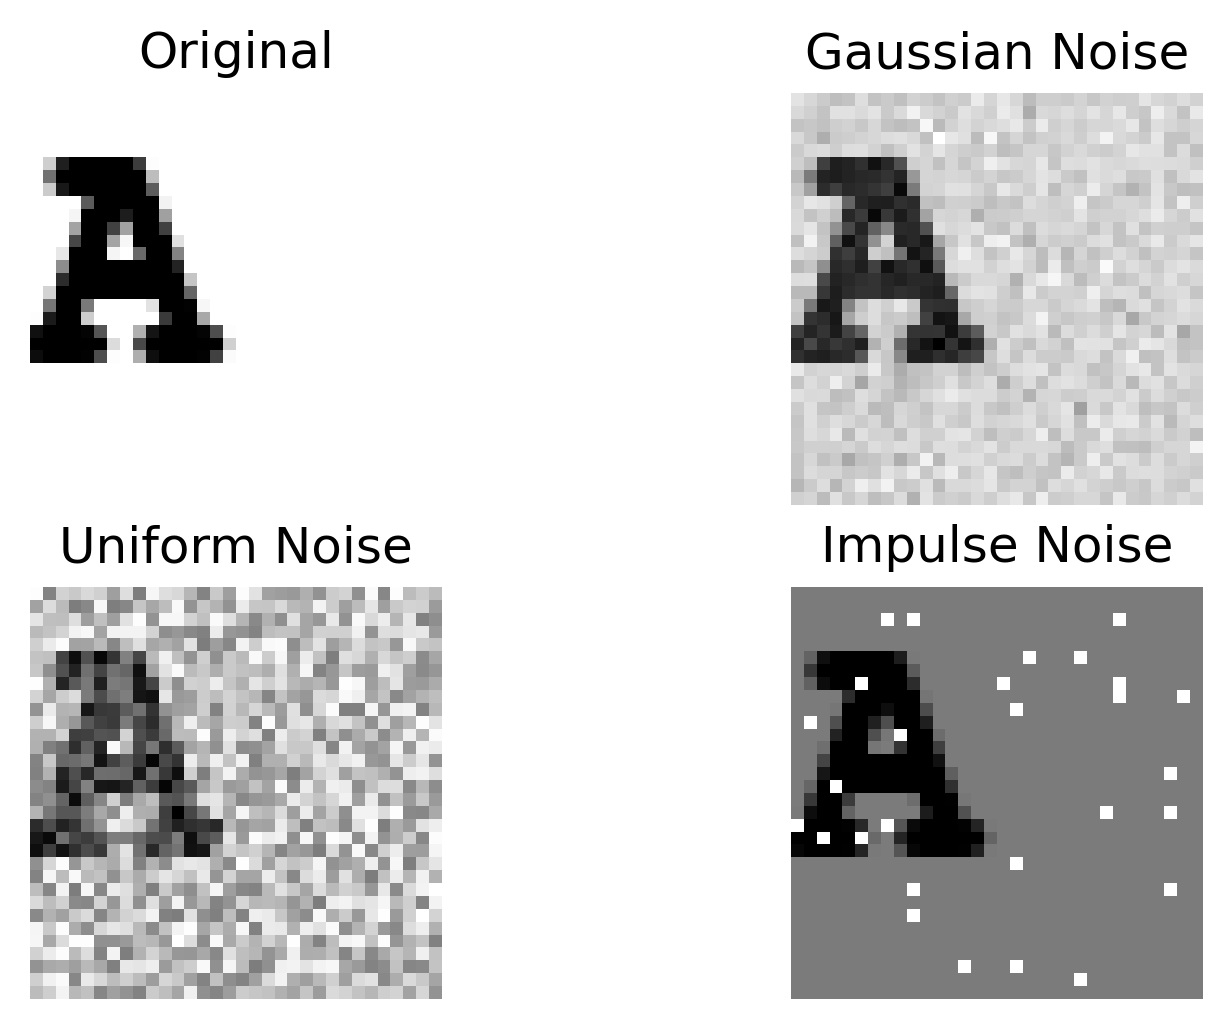

In [94]:
img = generate_simple_image()
fig=plt.figure(dpi=300)

fig.add_subplot(2,2,1)
plt.imshow(img)
plt.axis("off")
plt.title("Original")

fig.add_subplot(2,2,2)
plt.imshow(add_noise(img, 1))
plt.axis("off")
plt.title("Gaussian Noise")

fig.add_subplot(2,2,3)
plt.imshow(add_noise(img, 2))
plt.axis("off")
plt.title("Uniform Noise")

fig.add_subplot(2,2,4)
plt.imshow(add_noise(img, 3))
plt.axis("off")
plt.title("Impulse Noise")

In [96]:
# делаем обобщение для различных позиций и эффектов
def generate_image(letter: str = 'А', stroke_width: int = 1) -> np.ndarray:
    if not randint(0, 9):
        stroke_width = 0
    font_size = randint(20, 36)
    r = randint(10, 180)
    g = randint(10, 180)
    b = randint(10, 180)
    img =  Image.new("RGB", (32, 32), (r, g, b)).convert("L")
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("courier.ttf", font_size)
    start = (randint(0, 5), randint(0, 5)) if font_size < 30 else (0, 0)
    if not randint(0, 2):
        letter = ' ' + letter if font_size < 30 else letter
    if not randint(0, 2):
        letter = letter + ' ' if font_size < 30 else letter
    draw.text(start, letter, font=font, fill="black", stroke_width=1)
    
    return add_noise(np.array(img), randint(1, 3))

(-0.5, 31.5, 31.5, -0.5)

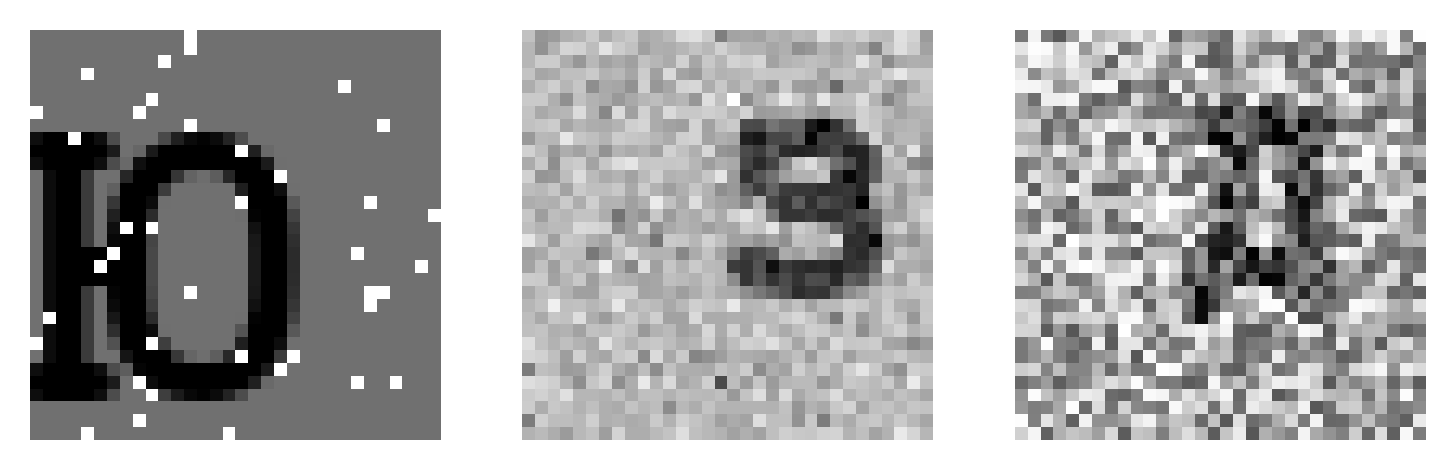

In [104]:
# для наглядности
fig=plt.figure(dpi=300)

fig.add_subplot(1,3,1)
plt.imshow(generate_image('Ю'))
plt.axis("off")

fig.add_subplot(1,3,2)
plt.imshow(generate_image('З'))
plt.axis("off")

fig.add_subplot(1,3,3)
plt.imshow(generate_image('Д'))
plt.axis("off")

In [105]:
# начинаем собирать датасет
# простая генерилка айдишек для кейсов
class GenId:
    
    def __init__(self):
        self.alphabet = string.ascii_lowercase + string.ascii_uppercase + string.digits
        self.ids = set()
    
    def generate_id(self):
        generated_id = ''
        for _ in range(10):
            generated_id += choice(self.alphabet)
        if generated_id in self.ids:
            generated_id = self.generate_id()
        self.ids.add(generated_id)
        return generated_id

In [106]:
first_letter = ord('А')
the_abc = ''.join([chr(i) for i in range(first_letter, first_letter+32)]) + 'Ё'

gen = GenId()
def data_generator():
    for target in range(len(the_abc)):
        for _ in range(randint(1000, 2000)):
            letter = the_abc[target]
            yield gen.generate_id(), target, letter, generate_image(letter)

In [107]:
# наш датасет готов
ids, targets, letters, images = [], [], [], []

for id_, target, letter, image_ in data_generator():
    ids.append(id_)
    targets.append(target)
    letters.append(letter)
    images.append(image_)
    
data = {
    'image_id': ids,
    'target': targets,
    'letter': letters,
    'image': images
        }

df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

In [108]:
df

,image_id,target,letter,image
0,s0DfC1qw2J,16,Р,"[[108, 108, 108, 255, 108, 108, 108, 108, 108,..."
1,NtBDguGHsd,25,Щ,"[[166, 182, 175, 174, 162, 170, 175, 170, 172,..."
2,ucEgjAE6IT,21,Х,"[[173, 173, 53, 88, 124, 94, 110, 102, 68, 70,..."
3,o3e434sDqh,16,Р,"[[155, 150, 157, 124, 145, 152, 141, 130, 155,..."
4,hswjSVsyeO,32,Ё,"[[185, 146, 119, 220, 135, 114, 179, 218, 126,..."
...,...,...,...,...
50732,qszsA6MR3Z,30,Ю,"[[115, 118, 134, 112, 126, 110, 103, 128, 113,..."
50733,jYeugHUgsl,20,Ф,"[[117, 220, 185, 160, 229, 161, 150, 126, 171,..."
50734,cA77bFCFSo,20,Ф,"[[193, 190, 192, 198, 176, 209, 191, 177, 197,..."
50735,OgDPUK4cYe,9,Й,"[[93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, ..."


In [109]:
# теперь его необходимо передать в torch формат
class ImageDataset(Dataset):
    def __init__(self, transform):
        
        self.transform = transform
        self.images =  df.image
        self.labels = df.target
        self.ids = df.image_id

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_ = self.images[idx]
        label_ = self.labels[idx]
        if self.transform:
            image_ = self.transform(image_)
        return image_, label_

In [110]:
# функция для разделения датасета, пока без валидации
def split_dataset(dset: Dataset, train_size: Union[float, int] = 0.9, seed: int = 42):
    dset_length = len(dset)
    train_size = floor(0.9 * dset_length)
    test_size = dset_length - train_size
    return random_split(dset, [train_size, test_size], generator=torch.Generator().manual_seed(seed))

In [111]:
# Копипаст с простой модели для MNIST с изменённым кол-вом нейронов в линейных слоях и, соответственно, 33 класса на выходе
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 128)
        self.fc2 = nn.Linear(128, 33)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [114]:
# ряд функций предобработки
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [115]:
train, test = split_dataset(ImageDataset(transform))

In [116]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=1000, shuffle=True)

In [117]:
# кол-во эпох взято заведомо большое
learning_rate = 0.01
momentum = 0.5
n_epochs = 20


network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [118]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(n_epochs + 1)]

In [119]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_dataloader.dataset),
            100. * batch_idx / len(train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_dataloader.dataset)))

In [120]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataloader.dataset),
    100. * correct / len(test_dataloader.dataset)))

In [121]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 3.4981, Accuracy: 144/5074 (3%)

Train Epoch: 1 [0/45663 (0%)]	Loss: 3.469696
Train Epoch: 1 [640/45663 (1%)]	Loss: 3.515889
Train Epoch: 1 [1280/45663 (3%)]	Loss: 3.499717
Train Epoch: 1 [1920/45663 (4%)]	Loss: 3.507417
Train Epoch: 1 [2560/45663 (6%)]	Loss: 3.502673
Train Epoch: 1 [3200/45663 (7%)]	Loss: 3.484010
Train Epoch: 1 [3840/45663 (8%)]	Loss: 3.468163
Train Epoch: 1 [4480/45663 (10%)]	Loss: 3.504977
Train Epoch: 1 [5120/45663 (11%)]	Loss: 3.486171
Train Epoch: 1 [5760/45663 (13%)]	Loss: 3.484796
Train Epoch: 1 [6400/45663 (14%)]	Loss: 3.515623
Train Epoch: 1 [7040/45663 (15%)]	Loss: 3.503736
Train Epoch: 1 [7680/45663 (17%)]	Loss: 3.513602
Train Epoch: 1 [8320/45663 (18%)]	Loss: 3.500899
Train Epoch: 1 [8960/45663 (20%)]	Loss: 3.470247
Train Epoch: 1 [9600/45663 (21%)]	Loss: 3.498546
Train Epoch: 1 [10240/45663 (22%)]	Loss: 3.495253
Train Epoch: 1 [10880/45663 (24%)]	Loss: 3.520530
Train Epoch: 1 [11520/45663 (25%)]	Loss: 3.512910
Train Epoch: 1 [12160/

In [123]:
# загружаем обрезанную букву из реального фото паспорта
a = cv2.imread('/kaggle/input/letters/.jpeg', cv2.IMREAD_GRAYSCALE)
a = cv2.resize(a, (32, 32))

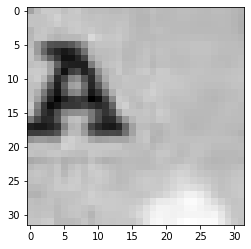

In [124]:
plt.imshow(a)

In [128]:
k = cv2.imread('/kaggle/input/letters2/.jpeg', cv2.IMREAD_GRAYSCALE)
k = cv2.resize(k, (32, 32))

In [130]:
A = torch.from_numpy(a).unsqueeze(0).double()

In [132]:
network.double()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=500, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=33, bias=True)
)

In [133]:
with torch.no_grad():
    output_a = network(A)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [134]:
ind = output_a.data.max(1, keepdim=True)[1][0].item()

In [135]:
the_abc[ind]

'А'